# Chinese OCR simple testing

import packages

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from alfred.utils.log import logger as logging
from tensorflow.keras.applications import EfficientNetB0
import pickle



## load datasets
load data from directory "dataset". The format is stored as tfrecord.

In [69]:
# some necesary parameters for model
IMG_SIZE = 224

In [70]:
def parse_example_v2(record):
    """
    latest version format
    :param record:
    :return:
    """
    features = tf.io.parse_single_example(record,
                                          features={
                                              'width':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'height':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'label':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'image':
                                                  tf.io.FixedLenFeature([], tf.string),
                                          })
    img = tf.io.decode_raw(features['image'], out_type=tf.uint8)
    # we can not reshape since it stores with original size
    w = tf.cast(features['width'], tf.int32)
    h = tf.cast(features['height'], tf.int32)
    img = tf.cast(tf.reshape(img, (w, h)), dtype=tf.float32)
    img = tf.expand_dims(img, axis=-1)  # adds extra dimension
    #to rgb
    img = tf.image.grayscale_to_rgb(img)

    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    


    label = tf.cast(features['label'], tf.int64)
    return {'image': img, 'label': label}



def load_ds(filedir):
    input_files = [filedir]
    ds = tf.data.TFRecordDataset(input_files)
    ds = ds.map(parse_example_v2)
    return ds

In [71]:
train_ds = load_ds('dataset/train.tfrecord') # read train.tfrecord
test_ds = load_ds('dataset/test.tfrecord')

In [72]:
train_ds
test_ds
train_mapped = train_ds.shuffle(100).batch(32).repeat()
train_mapped


<RepeatDataset element_spec={'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

In [73]:
# plot the image in the tfrecord
def plot_img(ds, characters, num =1):
    for i, data in enumerate(ds.take(num)):
        img = data['image'].numpy()
        print(img.shape)

        label = data['label'].numpy()
        plt.imshow(img[:,:,0])
        print(characters[label])
        plt.show()



## Training

In [74]:
# some arguments
target_size = 224
num_classes = 7356
batch_size = 32
# use_keras_fit = False
use_keras_fit = True
ckpt_path = './checkpoints/cn_ocr-{epoch}.ckpt'
this_dir = os.path.dirname(os.path.abspath("__file__"))
train_path = 'dataset/train.tfrecord'
test_path = 'dataset/test.tfrecord'

In [75]:
def load_characters():
    a = open(os.path.join(this_dir, 'dataset\\characters.txt'), 'r').readlines()
    return [i.strip() for i in a]

def preprocess(x):
    """
    minus mean pixel or normalize?
    """
    # original is 64x64, add a channel dim
    # x['image'] = tf.expand_dims(x['image'], axis=-1)
    # x['image'] = tf.image.resize(x['image'], (target_size, target_size))
    # x['image'] = (x['image'] - 128.) / 128.
    return x['image'], x['label']



In [76]:
# model
# efficientnet model with tensorflow
# def effcientnetB0_model(pretrained_weights=None):
#     inputs = layers.Input(shape=(target_size, target_size, 1))
#     x = layers.Conv2D(1, 3, padding='same')(inputs)
#     x = EfficientNetB0(include_top=True, input_tensor=x, weights=pretrained_weights)(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(num_classes, activation='softmax')(x)
#     model = keras.Model(inputs, x)
#     return model


def effcientnetB0_model(pretrained_weights=None):
    inputs = layers.Input(shape=(target_size, target_size, 3))  # EfficientNetB0 expects 3 channels
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=x)
    return model
    

In [77]:
# presets
all_characters = load_characters()
num_classes = len(all_characters)
logging.info('all characters: {}'.format(num_classes))

12:49:10 05.28 INFO 1629866278.py:4]: all characters: 3755


In [78]:
# logging callbacks
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, history_path):
        super().__init__()
        self.history_path = history_path
        if os.path.exists(self.history_path):
            with open(self.history_path, 'rb') as f:
                self.history = pickle.load(f)
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key in logs:
            if key in self.history:
                self.history[key].append(logs[key])
            else:
                self.history[key] = [logs[key]]

    def on_train_end(self, logs=None):
        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history, f)

(224, 224, 3)
角


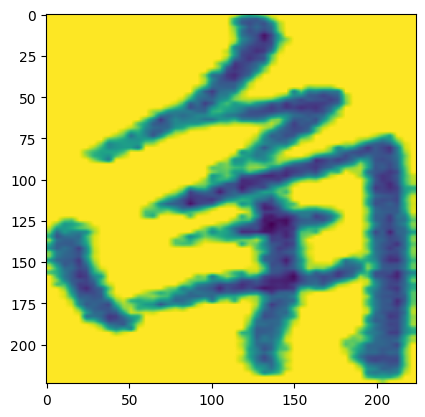

In [79]:
# demonstrate the dataset
train_dataset = load_ds(train_path)

plot_img(train_dataset, all_characters, num=1)

In [82]:

def train():

    history_path = 'history.pickle'
    save_history_callback = SaveHistoryCallback(history_path)

    train_dataset = load_ds(train_path)
    train_dataset = train_dataset.shuffle(100).map(preprocess).batch(batch_size).repeat()

    val_ds = load_ds(test_path)
    val_ds = val_ds.shuffle(100).map(preprocess).batch(batch_size).repeat()


    # init model
    model = effcientnetB0_model(pretrained_weights='imagenet')
    model.summary()

    logging.info('model loaded.')

    start_epoch = 0
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(ckpt_path))
    # latest_ckpt = False
    if latest_ckpt:
        start_epoch = int(latest_ckpt.split('-')[1].split('.')[0])
        model.load_weights(latest_ckpt)
        logging.info('model resumed from: {}, start at epoch: {}'.format(latest_ckpt, start_epoch))
    else:
        logging.info('passing resume since weights not there. training from scratch')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_freq='epoch',
                                            save_best_only=True),
        save_history_callback
    ]
    try:
        model.fit(
            train_dataset,
            validation_data=val_ds,
            validation_steps=1000,
            epochs=100,
            steps_per_epoch=1024,
            callbacks=callbacks,
            use_multiprocessing=True)
    except KeyboardInterrupt:
        # model.save_weights(ckpt_path.format(epoch=0))
        logging.info('keras model saved.')
        save_history_callback.on_train_end()
        return model # return the model if training is interrupted
    model.save_weights(ckpt_path.format(epoch=0))
    model.save(os.path.join(os.path.dirname(ckpt_path), 'cn_ocr.h5'))
    
    return model

In [85]:
model = train()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_30 (Rescaling)       (None, 224, 224, 3)  0           ['input_16[0][0]']               
                                                                                                  
 normalization_15 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_30[0][0]']           
 n)                                                                                               
                                                                                           

13:13:05 05.28 INFO 2705960793.py:17]: model loaded.
13:13:06 05.28 INFO 2705960793.py:25]: model resumed from: ./checkpoints\cn_ocr-0.ckpt, start at epoch: 0


Epoch 1/100
1024/1024 [==============================] - ETA: 0s - loss: 5.4339 - accuracy: 0.0084
Epoch 1: val_loss improved from inf to 8.45861, saving model to ./checkpoints\cn_ocr-1.ckpt
1024/1024 [==============================] - 166s 156ms/step - loss: 5.4339 - accuracy: 0.0084 - val_loss: 8.4586 - val_accuracy: 0.0043
Epoch 2/100
1024/1024 [==============================] - ETA: 0s - loss: 5.0033 - accuracy: 0.0206
Epoch 2: val_loss did not improve from 8.45861
1024/1024 [==============================] - 156s 152ms/step - loss: 5.0033 - accuracy: 0.0206 - val_loss: 15.3783 - val_accuracy: 0.0020
Epoch 3/100
 612/1024 [================>.............] - ETA: 50s - loss: 4.5287 - accuracy: 0.0362

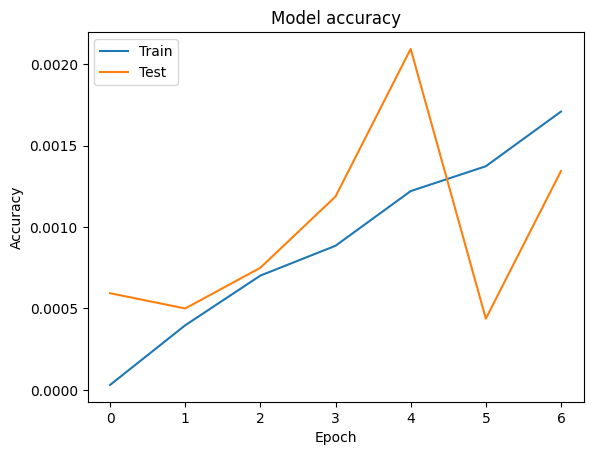

In [84]:
# plot val accuracy
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Display predictions


In [ ]:
# display the result
def display_result(model, ds, characters, num=1):
    for i, data in enumerate(ds.take(num)):
        img = data['image'].numpy()
        label = data['label'].numpy()
        plt.imshow(img[:,:,0])
        plt.show()
        pred = model.predict(tf.expand_dims(img, axis=0))
        pred = np.argmax(pred, axis=-1)[0]
        print('pred: {}, label: {}'.format(characters[pred], characters[label]))

In [ ]:
display_result(model, test_ds, all_characters, num=1)

NameError: name 'model' is not defined